In [1]:
import igraph as ig
import sknetwork as sn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, accuracy_score, recall_score
from tqdm import trange, tqdm
from abcd_graph import ABCDGraph, ABCDParams

from itertools import product
import sys
import os
sys.path.append('../')
from CAS import *

import ecg_igraph as ecg_igraph

## Generate ABCD+o graphs using Julia

In [2]:
## utility function - we fix all the parameters in the experiments below and only vary xi
def build_ABCDo(xi, nout, num_nodes=10000):
    params = ABCDParams(
        vcount=num_nodes, 
        gamma=2.5,
        min_degree=5,
        max_degree=int(num_nodes**.5),
        beta=1.5,
        min_community_size=50,
        max_community_size=int(num_nodes**.767),
        xi=xi,
        num_outliers=nout,
    )    
    G = ABCDGraph(params)
    G.build()
    g = G.exporter.to_igraph()
    c = np.array(g.vs['ground_truth_community']) ## outliers have community 0 instead of -1

    return g, c

## 3x3 ROC curves

100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


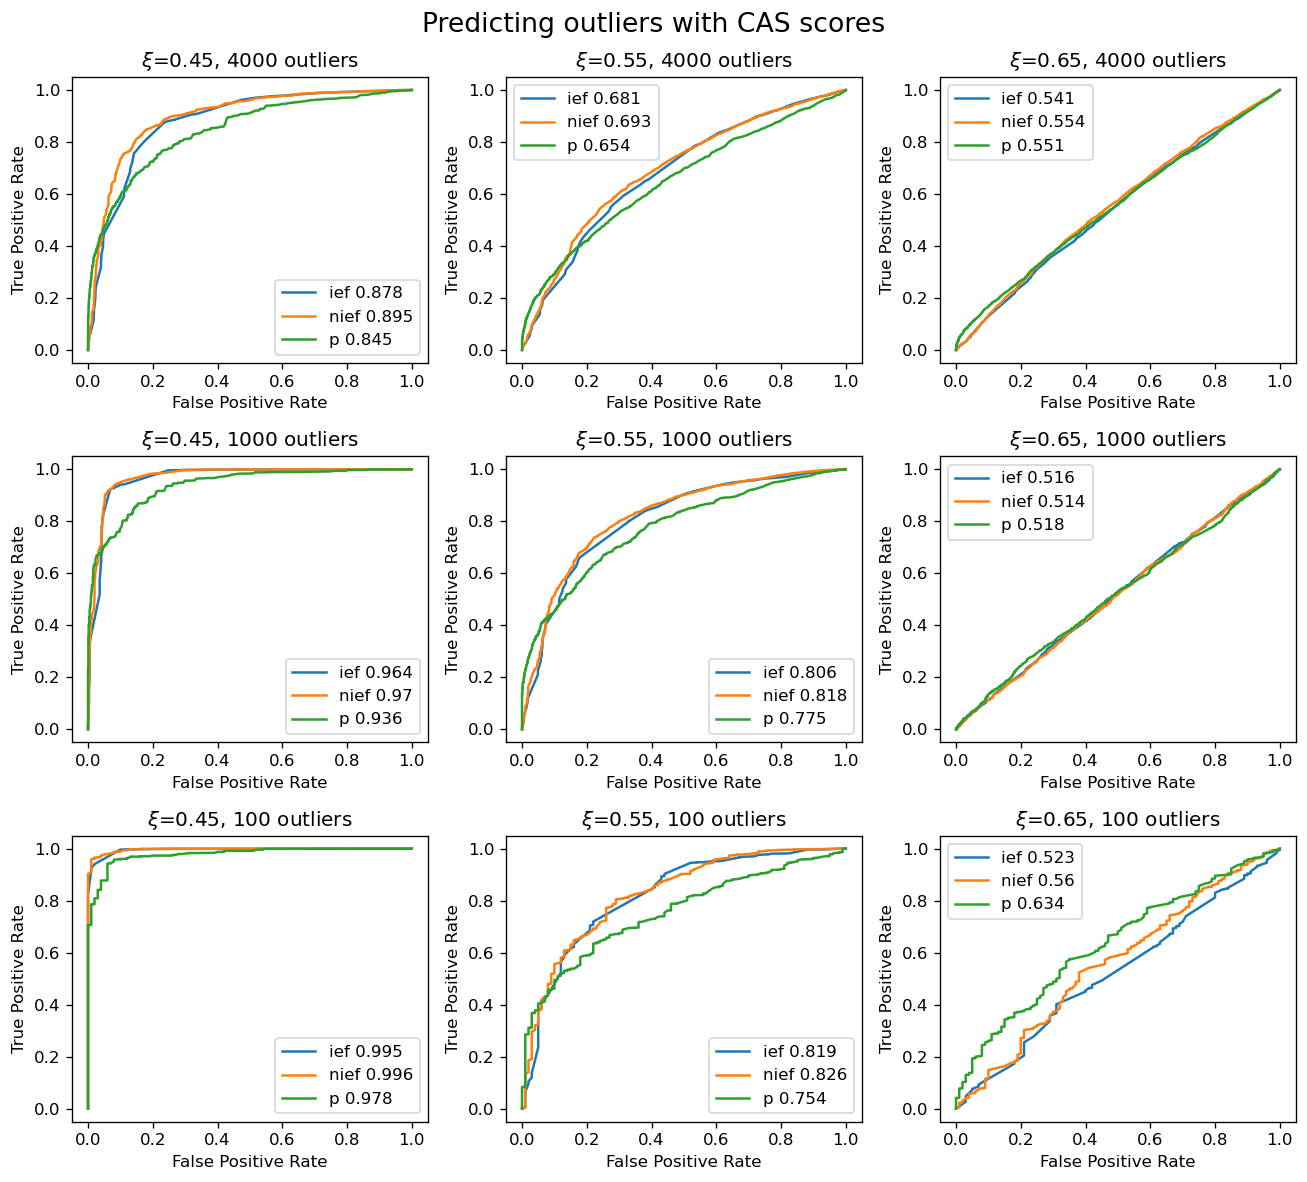

In [4]:
# Params
n = 10000
NOUTS = [4000, 1000, 100]
XIS = [.45, .55, .65]

fig, axs = plt.subplots(3, 3, figsize=(11, 10))
with tqdm(total=9) as pbar:
    for i, nout in enumerate(NOUTS):
        for j, xi in enumerate(XIS):
            g, c = build_ABCDo(xi, nout, n)
            is_not_outlier = c != -1
            com = np.array(g.community_leiden(objective_function="modularity").membership)
            #print(f"Leiden detected {np.max(com)+1} communities, gt has {np.max(c)+1}")
            #options = [
            #    ["IEF COUT", ecg_igraph.ief_to_cluster],
            #    ["NIEF COUT", ecg_igraph.nief_to_cluster],
            #    ["P COUT", ecg_igraph.p_to_cluster],
            #    ["ECG COUT", ecg_igraph.ecg_to_cluster]
            #]
            #for name, cas in options:
            #    g.es["w"] = ecg_igraph.ensemble_edge_weights(g, cas=cas)
            #    adj = g.get_adjacency_sparse(attribute="w")
            #    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="cout")
            #    fpr, tpr, thresholds = roc_curve(is_not_outlier, scores, pos_label=1)
            #    axs[i, j].plot(fpr, tpr, label=name+" "+str(round(AUC(is_not_outlier, scores),3)))

            options = ["ief", "nief", "p"]
            for name in options:
                adj = g.get_adjacency_sparse()
                scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score=name)
                #print(any(np.isnan(scores)))
                #print(name, f"min score: {np.min(scores)}, max: {np.max(scores)}")
                fpr, tpr, thresholds = roc_curve(is_not_outlier, scores, pos_label=1)
                axs[i, j].plot(fpr, tpr, label=name+" "+str(round(AUC(is_not_outlier, scores),3)))

            axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")
            axs[i, j].set_xlabel("False Positive Rate")
            axs[i, j].set_ylabel("True Positive Rate")
            axs[i, j].legend()
            pbar.update()

plt.suptitle("Predicting outliers with CAS scores", fontsize=16)
fig = plt.gcf()
fig.set_size_inches(11, 10)
fig.set_dpi(120)
fig.tight_layout()
#fig.savefig("outlier-roc.png")

  0%|          | 0/360 [00:00<?, ?it/s]/home/rdewolfe/research/CommunityAssociationStrength/ECG/ecg_igraph.py:228: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(adjacent_clusters)):
100%|██████████| 1800/1800 [07:18<00:00,  4.11it/s]


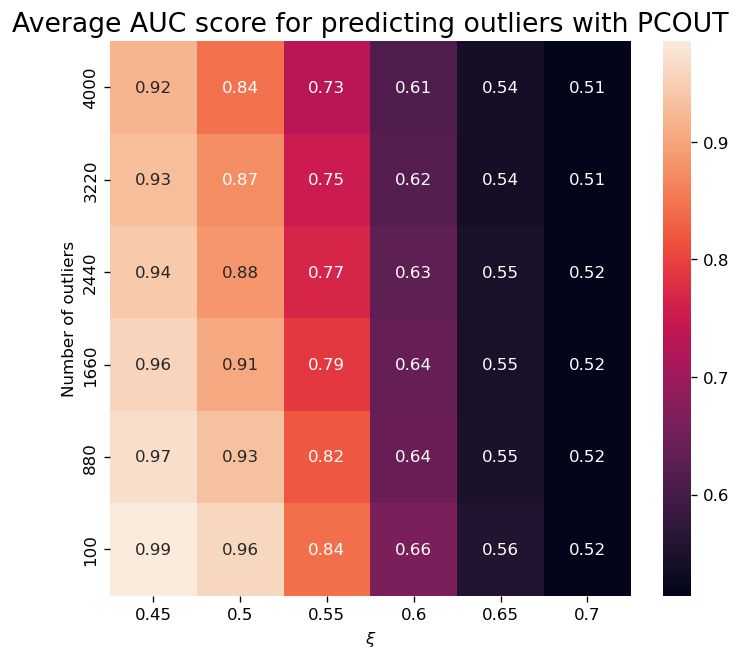

In [5]:
## For one pruning method, make a heatmap of average AUC score
REP = 10
n = 10000
XIS = np.round(np.linspace(0.5, 0.75, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    g.es["w"] = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.p_to_cluster)
    adj = g.get_adjacency_sparse(attribute="w")
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="cout")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

## For one pruning method, make a heatmap of average AUC score
REP = 50
n = 10000
XIS = np.round(np.linspace(0.45, 0.7, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    adj = g.get_adjacency_sparse()
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="ief")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

sns.heatmap(np.flip(np.mean(aucs, axis=2), axis=1).T, xticklabels=XIS, yticklabels=NOUTS[::-1], annot=True)
plt.xlabel(r"$\xi$")
plt.ylabel("Number of outliers")
plt.title("Average AUC score for predicting outliers with PCOUT", fontsize=16)

fig = plt.gcf()
fig.set_size_inches(7, 6)
fig.set_dpi(120)
fig.savefig("outlier-auc-pcout.png")

100%|██████████| 1800/1800 [07:17<00:00,  4.11it/s]


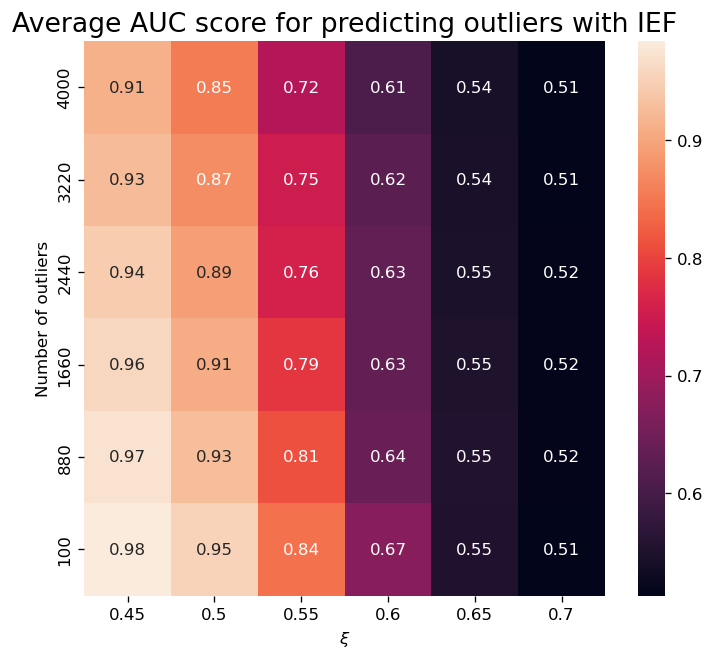

In [6]:
## For one pruning method, make a heatmap of average AUC score
REP = 50
n = 10000
XIS = np.round(np.linspace(0.45, 0.7, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    adj = g.get_adjacency_sparse()
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="ief")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

sns.heatmap(np.flip(np.mean(aucs, axis=2), axis=1).T, xticklabels=XIS, yticklabels=NOUTS[::-1], annot=True)
plt.xlabel(r"$\xi$")
plt.ylabel("Number of outliers")
plt.title("Average AUC score for predicting outliers with IEF", fontsize=16)

fig = plt.gcf()
fig.set_size_inches(7, 6)
fig.set_dpi(120)
fig.savefig("outlier-auc-ief.png")

100%|██████████| 1800/1800 [07:18<00:00,  4.10it/s]


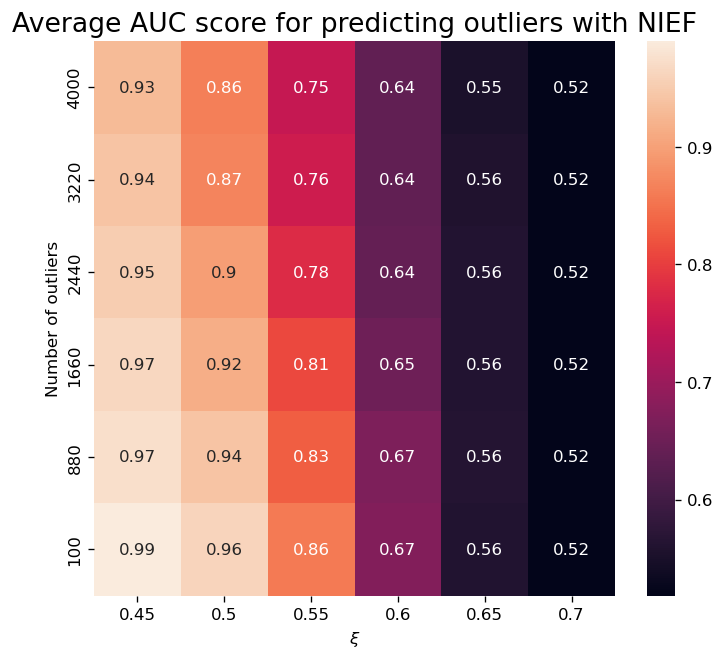

In [7]:
## For one pruning method, make a heatmap of average AUC score
REP = 50
n = 10000
XIS = np.round(np.linspace(0.45, 0.7, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    adj = g.get_adjacency_sparse()
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="nief")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

sns.heatmap(np.flip(np.mean(aucs, axis=2), axis=1).T, xticklabels=XIS, yticklabels=NOUTS[::-1], annot=True)
plt.xlabel(r"$\xi$")
plt.ylabel("Number of outliers")
plt.title("Average AUC score for predicting outliers with NIEF", fontsize=16)

fig = plt.gcf()
fig.set_size_inches(7, 6)
fig.set_dpi(120)
fig.savefig("outlier-auc-nief.png")

100%|██████████| 1800/1800 [07:32<00:00,  3.98it/s]


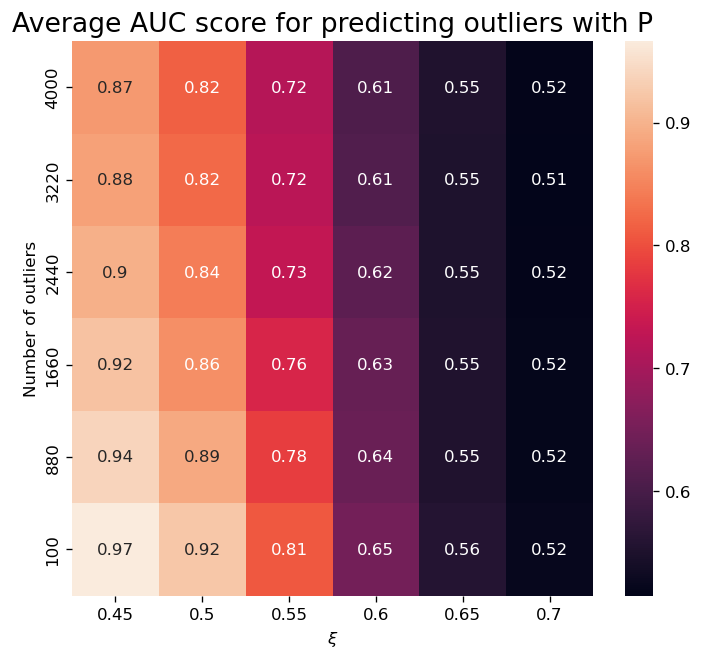

In [8]:
## For one pruning method, make a heatmap of average AUC score
REP = 50
n = 10000
XIS = np.round(np.linspace(0.45, 0.7, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    adj = g.get_adjacency_sparse()
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="p")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

sns.heatmap(np.flip(np.mean(aucs, axis=2), axis=1).T, xticklabels=XIS, yticklabels=NOUTS[::-1], annot=True)
plt.xlabel(r"$\xi$")
plt.ylabel("Number of outliers")
plt.title("Average AUC score for predicting outliers with P", fontsize=16)

fig = plt.gcf()
fig.set_size_inches(7, 6)
fig.set_dpi(120)
fig.savefig("outlier-auc-p.png")

## If we prune (and recalculate) up to a moderate threshhold does it prune the whole graph?

In [12]:
# Params
REP = 50
n = 10000
NOUTS = [100, 1000, 4000]
XIS = [.4, .5, .6]
ief_cuts = np.linspace(0.1, 0.8, 71)
p_cuts = np.linspace(0.8, 0.999, 71)
# Initialize results storage
#pcout_pruned_rec = np.empty((REP, len(XIS), len(NOUTS), len(cuts), n), dtype="bool")
#niefcout_pruned_rec = np.empty_like(pcout_pruned_rec)
#iefcout_pruned_rec = np.empty_like(pcout_pruned_rec)
#ecgcout_pruned_rec = np.empty_like(pcout_pruned_rec)

p_pruned_rec = np.empty((REP, len(XIS), len(NOUTS), len(ief_cuts), n), dtype="bool")
nief_pruned_rec = np.empty_like(p_pruned_rec)
ief_pruned_rec = np.empty_like(p_pruned_rec)

p_pruned_one = np.empty_like(p_pruned_rec)
nief_pruned_one = np.empty_like(p_pruned_rec)
ief_pruned_one = np.empty_like(p_pruned_rec)

gts = np.empty((REP, len(XIS), len(NOUTS), n), dtype="int32")
coms = np.empty((REP, len(XIS), len(NOUTS), n), dtype="int32")

# Compute
with tqdm(total=REP*len(XIS)*len(NOUTS)) as pbar:
    for rep in range(REP):
        for i, xi in enumerate(XIS):
            for j, nout in enumerate(NOUTS):

                g, gt = build_ABCDo(xi, nout, num_nodes=n)
                gts[rep, i, j, :] = gt

                #ief = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.ief_to_cluster)
                #nief = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.nief_to_cluster)
                #p = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.p_to_cluster)
                #ecg = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.ecg_to_cluster)

                com = np.array(g.community_leiden(objective_function="modularity").membership)
                coms[rep, i, j, :] = com

                for k, c in enumerate(ief_cuts):
                    #iefcout_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="cout", edge_weights=ief)
                    #niefcout_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="cout", edge_weights=nief)
                    #pcout_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="cout", edge_weights=p)
                    #ecgcout_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="cout", edge_weights=ecg)

                    #iefcout_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
                    #niefcout_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
                    #pcout_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
                    #ecgcout_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

                    ief_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="ief")
                    nief_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="nief")
                    #p_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="p")

                    ief_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="ief", max_per_round=n, recursive=False)
                    nief_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="nief", max_per_round=n, recursive=False)
                    #p_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="p", max_per_round=n, recursive=False)
        
                for k, c in enumerate(p_cuts):
                    p_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="p")
                    p_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="p", max_per_round=n, recursive=False)
                
                pbar.update()

100%|██████████| 450/450 [4:03:53<00:00, 32.52s/it]  


In [13]:
import pickle
data = {
    "p_pruned_rec": p_pruned_rec,
    "nief_pruned_rec": nief_pruned_rec,
    "ief_pruned_rec": ief_pruned_rec,
    "p_pruned_one": p_pruned_one,
    "nief_pruned_one": nief_pruned_one,
    "ief_pruned_one": ief_pruned_one,
    "gts": gts,
    "coms": coms
}
with open("outlier_test.pkl", "wb") as f:
    pickle.dump(data, f)

In [7]:
import pickle
with open("outlier_test.pkl", "rb") as f:
    data = pickle.load(f)

pcout_pruned_rec = data["pcout_pruned_rec"]
niefcout_pruned_rec = data['niefcout_pruned_rec']
iefcout_pruned_rec = data['iefcout_pruned_rec']
ecgcout_pruned_rec = data['ecgcout_pruned_rec']
p_pruned_rec = data['p_pruned_rec']
nief_pruned_rec = data['nief_pruned_rec']
ief_pruned_rec = data['ief_pruned_rec']
gts = data['gts']
coms = data['coms']

REP = 50
n = 10000
NOUTS = [100, 1000, 4000]
XIS = [.45, .55, .65]
ief_cuts = np.linspace(0.1, 0.8, 71)
p_cuts = np.linspace(0.8, 0.999, 71)

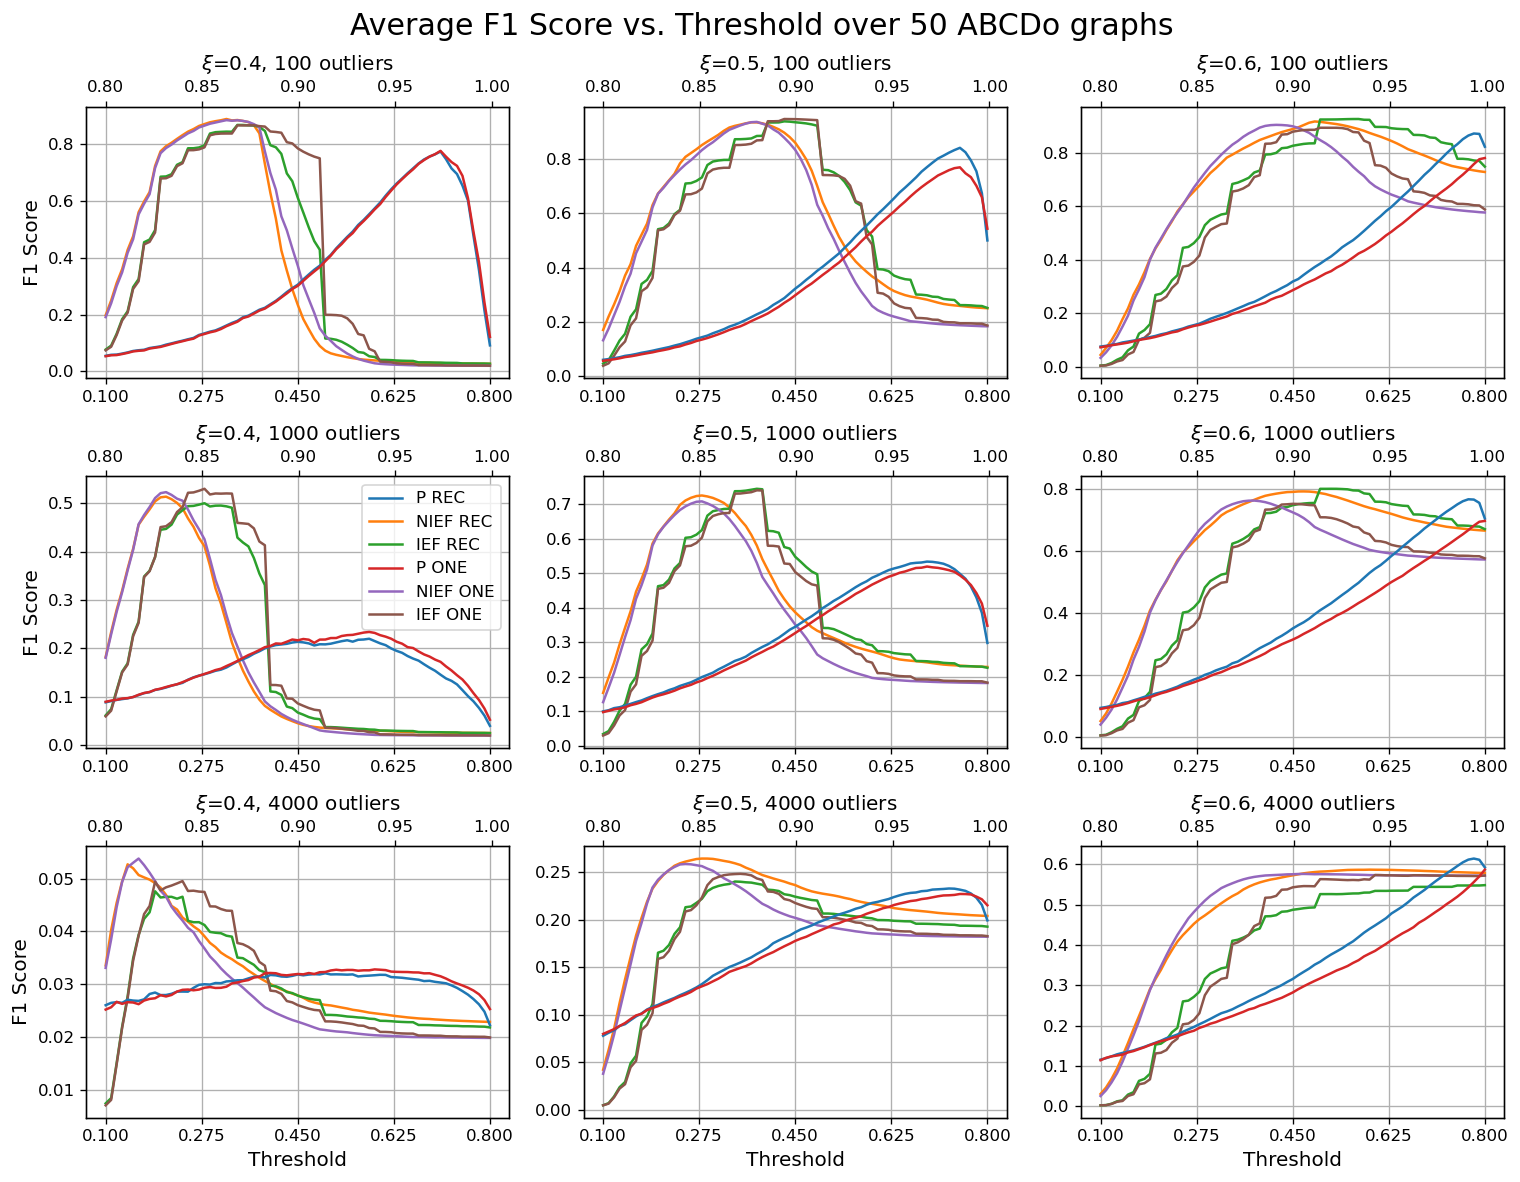

In [ ]:
def make_scores(score_function, pruned, gt):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == -1
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


options = [
    #[pcout_pruned_rec, "P COUT REC"],
    #[niefcout_pruned_rec, "NIEF COUT REC"],
    #[iefcout_pruned_rec, "IEF COUT REC"],
    #[ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    [p_pruned_one, "P ONE"],
    [nief_pruned_one, "NIEF ONE"],
    [ief_pruned_one, "IEF ONE"],
]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
colors = colors[:len(options)]

fig, axs = plt.subplots(3, 3)
for i, nout in enumerate(NOUTS):
    for j, xi in enumerate(XIS):
        lines = []
        twy = axs[i,j].twiny()
        for o, (pruned, name) in enumerate(options):
            f1 = np.mean(make_scores(f1_score, pruned[:, i, j, :, :], gts[:, i, j, :]), axis=0)
            if name in ["NIEF REC", "IEF REC", "NIEF ONE", "IEF ONE"]:
                lines += axs[i, j].plot(ief_cuts, f1, label=name, c=colors[o])
            elif name in ["P REC", "P ONE"]:
                lines += twy.plot(p_cuts, f1, label=name, c=colors[o])
            else:
                print("No cuts option!")
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 5
        ief_ticks = np.linspace(np.min(ief_cuts), np.max(ief_cuts), n_ticks)
        axs[i,j].set_xticks(ief_ticks)
        p_ticks = np.linspace(np.min(p_cuts), 1, n_ticks)
        twy.set_xticks(p_ticks)

        axs[i, j].grid()
        axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("F1 Score", fontsize=12)
axs[1, 0].set_ylabel("F1 Score", fontsize=12)
axs[2, 0].set_ylabel("F1 Score", fontsize=12)
axs[2, 0].set_xlabel("Threshold", fontsize=12)
axs[2, 1].set_xlabel("Threshold", fontsize=12)
axs[2, 2].set_xlabel("Threshold", fontsize=12)
axs[1, 0].legend(lines, labels)
plt.suptitle(f"Average F1 Score vs. Threshold on ABCD+o", fontsize=18)

fig = plt.gcf()
fig.set_size_inches(12.8, 10)
fig.set_dpi(120)
fig.tight_layout()

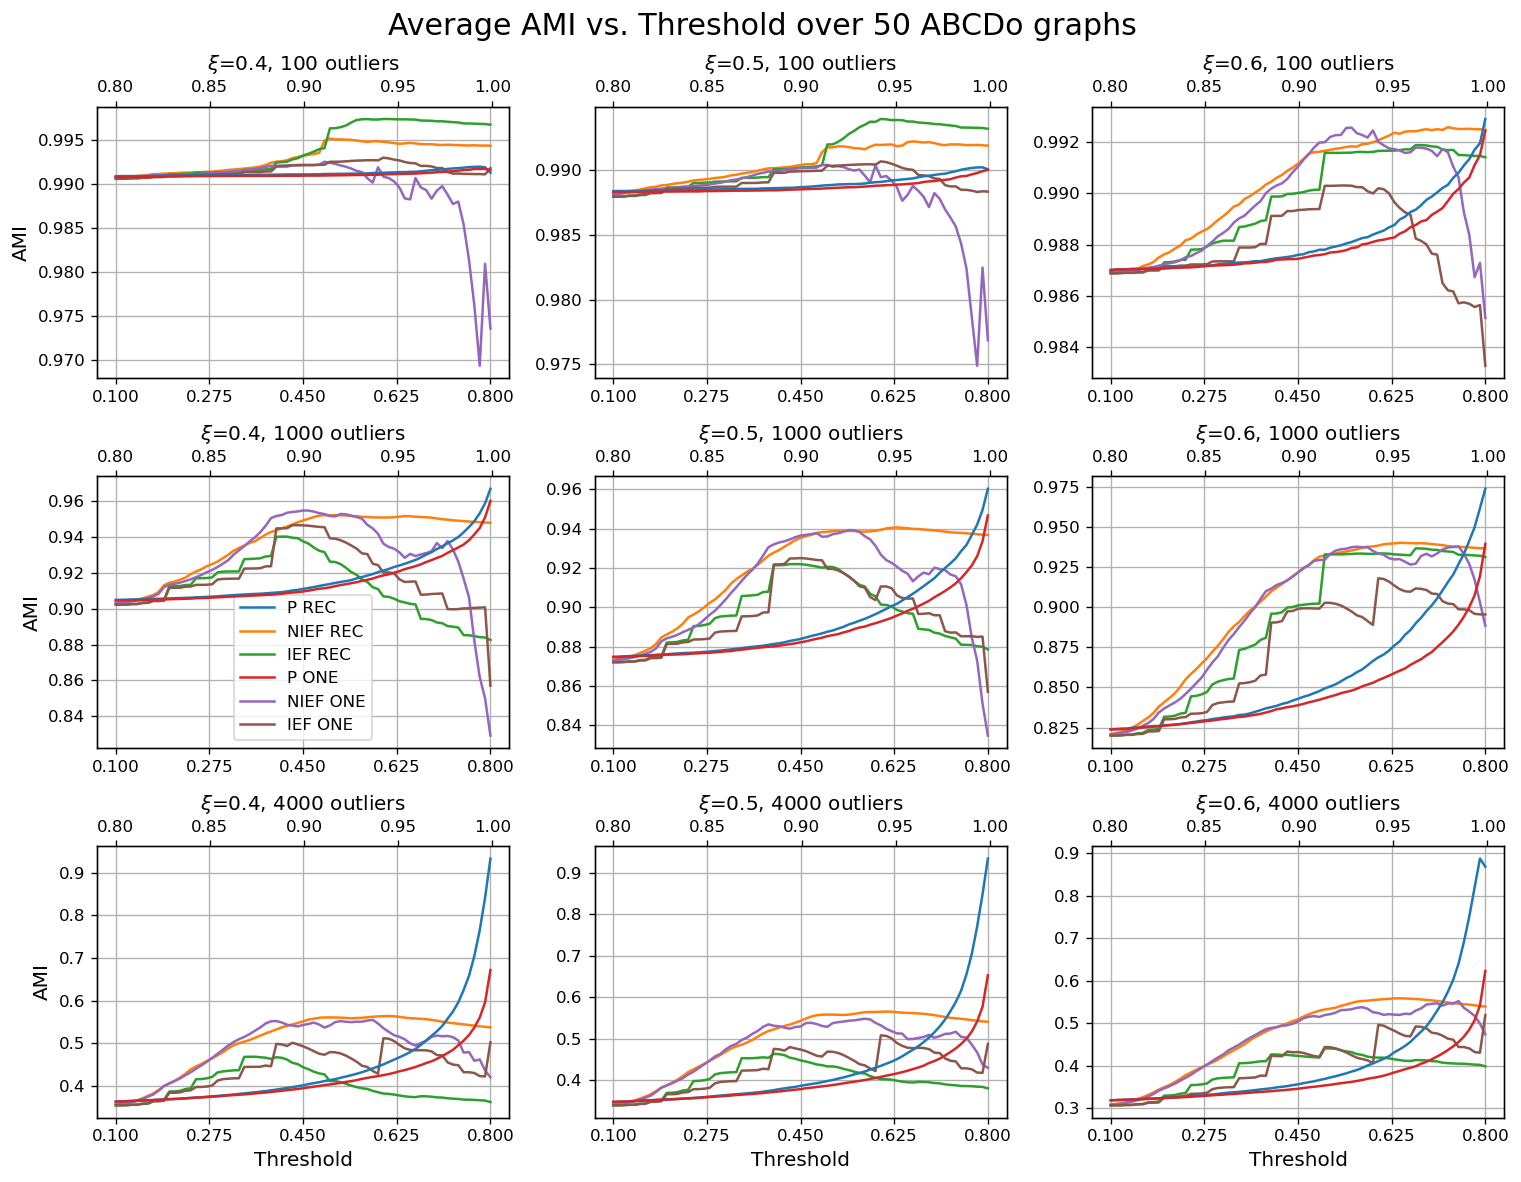

In [15]:
def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == -1, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    #[pcout_pruned_rec, "P COUT REC"],
    #[niefcout_pruned_rec, "NIEF COUT REC"],
    #[iefcout_pruned_rec, "IEF COUT REC"],
    #[ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    [p_pruned_one, "P ONE"],
    [nief_pruned_one, "NIEF ONE"],
    [ief_pruned_one, "IEF ONE"],
]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
colors = colors[:len(options)]

fig, axs = plt.subplots(3, 3)
for i, nout in enumerate(NOUTS):
    for j, xi in enumerate(XIS):
        lines = []
        twy = axs[i,j].twiny()
        for o, (pruned, name) in enumerate(options):
            f1 = np.mean(make_ami_scores(pruned[:, i, j, :, :], gts[:, i, j, :], coms[:, i,j, :]), axis=0)
            if name in ["NIEF REC", "IEF REC", "NIEF ONE", "IEF ONE"]:
                lines += axs[i, j].plot(ief_cuts, f1, label=name, c=colors[o])
            elif name in ["P REC", "P ONE"]:
                lines += twy.plot(p_cuts, f1, label=name, c=colors[o])
            else:
                print(f"No cuts option for {name}")
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 5
        ief_ticks = np.linspace(np.min(ief_cuts), np.max(ief_cuts), n_ticks)
        axs[i,j].set_xticks(ief_ticks)
        p_ticks = np.linspace(np.min(p_cuts), 1, n_ticks)
        twy.set_xticks(p_ticks)

        axs[i, j].grid()
        axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("AMI", fontsize=12)
axs[1, 0].set_ylabel("AMI", fontsize=12)
axs[2, 0].set_ylabel("AMI", fontsize=12)
axs[2, 0].set_xlabel("Threshold", fontsize=12)
axs[2, 1].set_xlabel("Threshold", fontsize=12)
axs[2, 2].set_xlabel("Threshold", fontsize=12)
axs[1, 0].legend(lines, labels)
plt.suptitle(f"Average AMI vs. Threshold on ABCD+o", fontsize=18)

fig = plt.gcf()
fig.set_size_inches(12.8, 10)
fig.set_dpi(120)
fig.tight_layout()

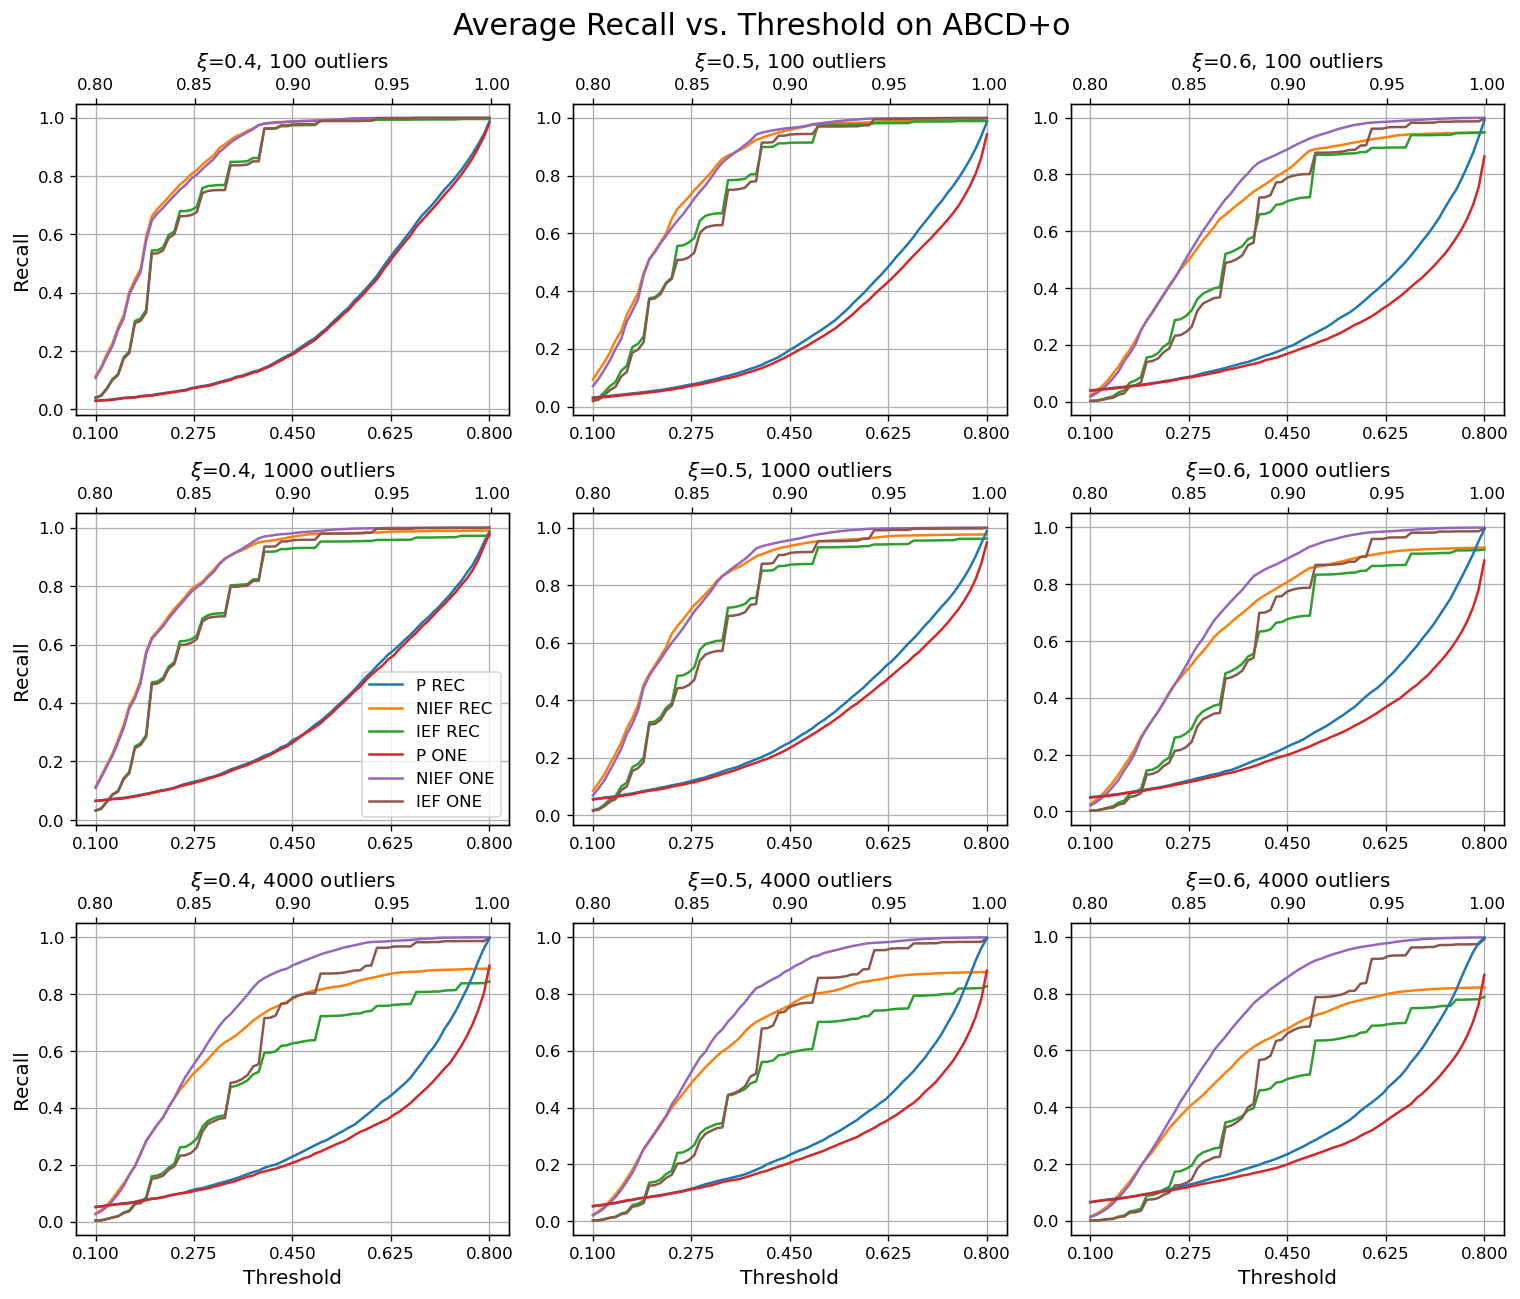

In [16]:
def make_scores(score_function, pruned, gt):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == -1
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


options = [
    #[pcout_pruned_rec, "P COUT REC"],
    #[niefcout_pruned_rec, "NIEF COUT REC"],
    #[iefcout_pruned_rec, "IEF COUT REC"],
    #[ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    [p_pruned_one, "P ONE"],
    [nief_pruned_one, "NIEF ONE"],
    [ief_pruned_one, "IEF ONE"],
]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
colors = colors[:len(options)]

fig, axs = plt.subplots(3, 3)
for i, nout in enumerate(NOUTS):
    for j, xi in enumerate(XIS):
        lines = []
        twy = axs[i,j].twiny()
        for o, (pruned, name) in enumerate(options):
            f1 = np.mean(make_scores(recall_score, pruned[:, i, j, :, :], gts[:, i, j, :]), axis=0)
            if name in ["NIEF REC", "IEF REC", "NIEF ONE", "IEF ONE"]:
                lines += axs[i, j].plot(ief_cuts, f1, label=name, c=colors[o])
            elif name in ["P REC", "P ONE"]:
                lines += twy.plot(p_cuts, f1, label=name, c=colors[o])
            else:
                print(f"No cuts option for {name}")
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 5
        ief_ticks = np.linspace(np.min(ief_cuts), np.max(ief_cuts), n_ticks)
        axs[i,j].set_xticks(ief_ticks)
        p_ticks = np.linspace(np.min(p_cuts), 1, n_ticks)
        twy.set_xticks(p_ticks)

        axs[i, j].grid()
        axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("Recall", fontsize=12)
axs[1, 0].set_ylabel("Recall", fontsize=12)
axs[2, 0].set_ylabel("Recall", fontsize=12)
axs[2, 0].set_xlabel("Threshold", fontsize=12)
axs[2, 1].set_xlabel("Threshold", fontsize=12)
axs[2, 2].set_xlabel("Threshold", fontsize=12)
axs[1, 0].legend(lines, labels)
plt.suptitle(f"Average Recall vs. Threshold on ABCD+o", fontsize=18)

fig = plt.gcf()
fig.set_size_inches(12.8, 11)
fig.set_dpi(120)
fig.tight_layout()

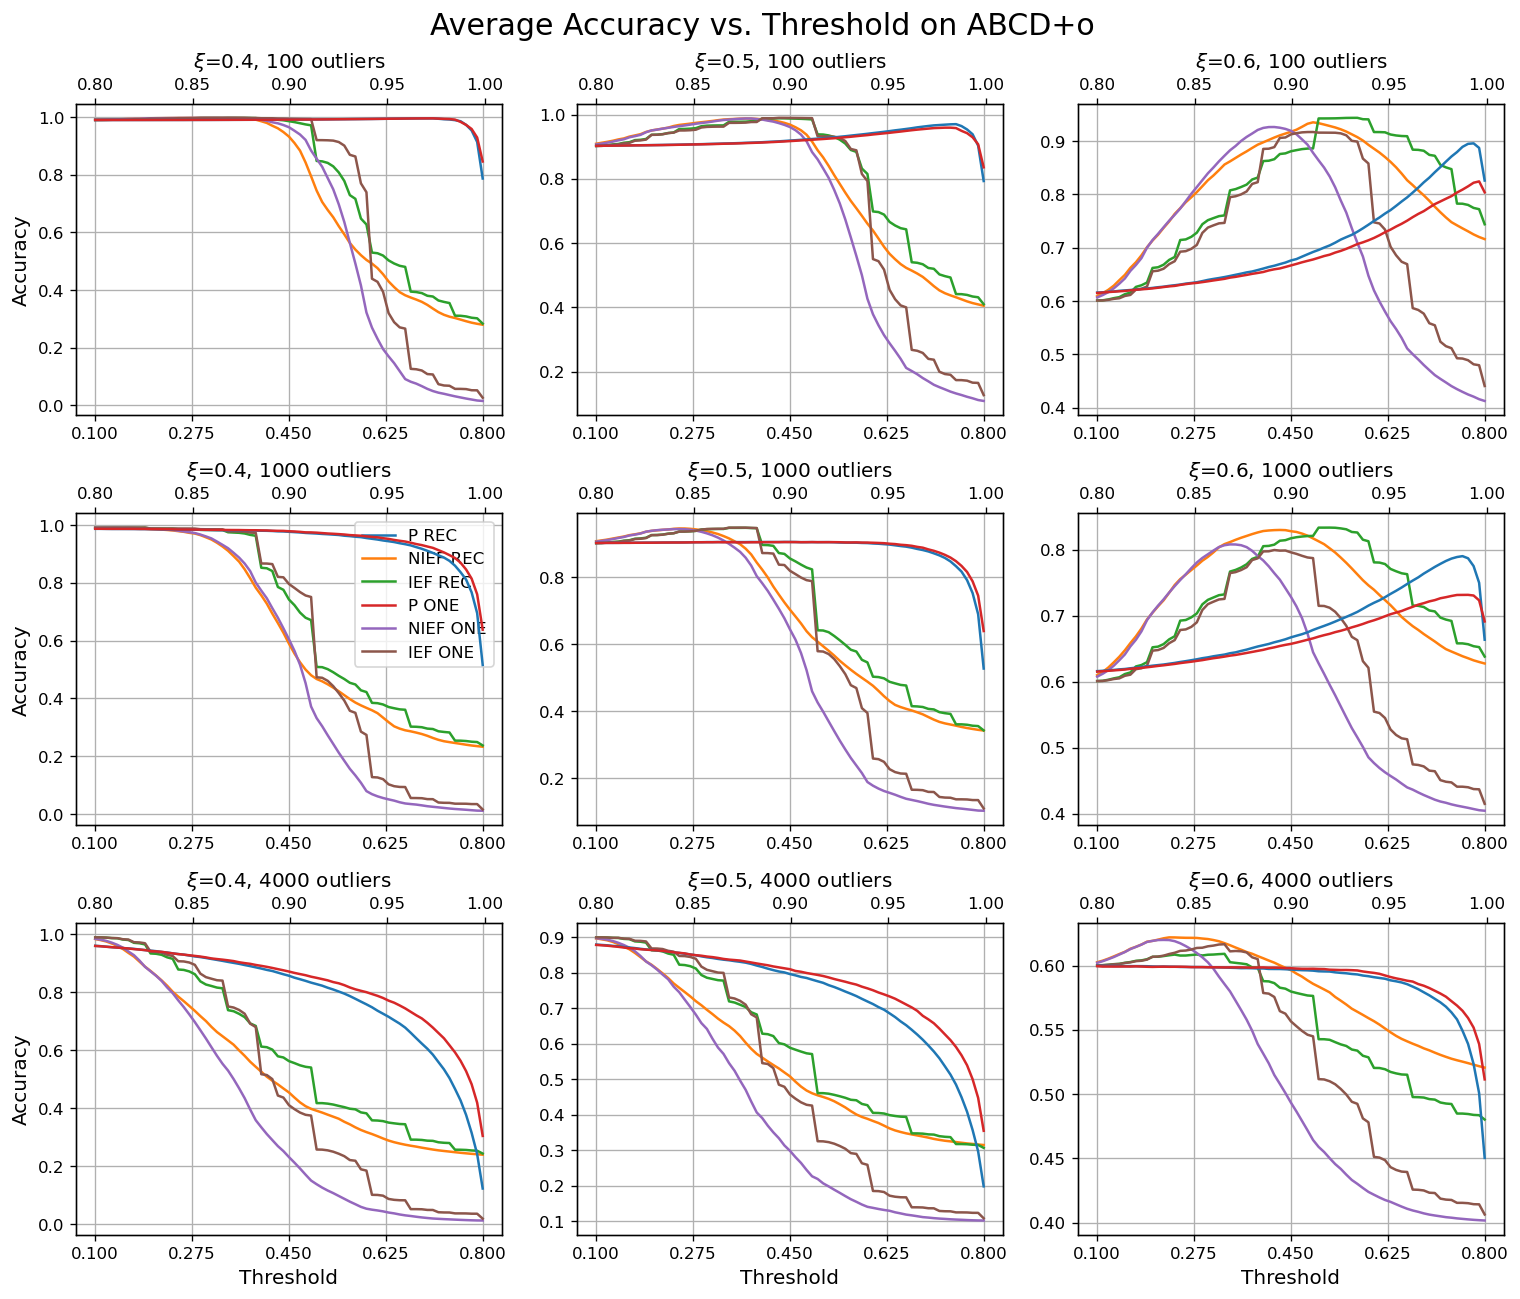

In [17]:
def make_scores(score_function, pruned, gt):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == -1
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


options = [
    #[pcout_pruned_rec, "P COUT REC"],
    #[niefcout_pruned_rec, "NIEF COUT REC"],
    #[iefcout_pruned_rec, "IEF COUT REC"],
    #[ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    [p_pruned_one, "P ONE"],
    [nief_pruned_one, "NIEF ONE"],
    [ief_pruned_one, "IEF ONE"],
]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
colors = colors[:len(options)]

fig, axs = plt.subplots(3, 3)
for i, nout in enumerate(NOUTS):
    for j, xi in enumerate(XIS):
        lines = []
        twy = axs[i,j].twiny()
        for o, (pruned, name) in enumerate(options):
            f1 = np.mean(make_scores(accuracy_score, pruned[:, i, j, :, :], gts[:, i, j, :]), axis=0)
            if name in ["NIEF REC", "IEF REC", "NIEF ONE", "IEF ONE"]:
                lines += axs[i, j].plot(ief_cuts, f1, label=name, c=colors[o])
            elif name in ["P REC", "P ONE"]:
                lines += twy.plot(p_cuts, f1, label=name, c=colors[o])
            else:
                print(f"No cuts option for {name}")
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 5
        ief_ticks = np.linspace(np.min(ief_cuts), np.max(ief_cuts), n_ticks)
        axs[i,j].set_xticks(ief_ticks)
        p_ticks = np.linspace(np.min(p_cuts), 1, n_ticks)
        twy.set_xticks(p_ticks)

        axs[i, j].grid()
        axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("Accuracy", fontsize=12)
axs[1, 0].set_ylabel("Accuracy", fontsize=12)
axs[2, 0].set_ylabel("Accuracy", fontsize=12)
axs[2, 0].set_xlabel("Threshold", fontsize=12)
axs[2, 1].set_xlabel("Threshold", fontsize=12)
axs[2, 2].set_xlabel("Threshold", fontsize=12)
axs[1, 0].legend(lines, labels)
plt.suptitle(f"Average Accuracy vs. Threshold on ABCD+o", fontsize=18)

fig = plt.gcf()
fig.set_size_inches(12.8, 11)
fig.set_dpi(120)
fig.tight_layout()

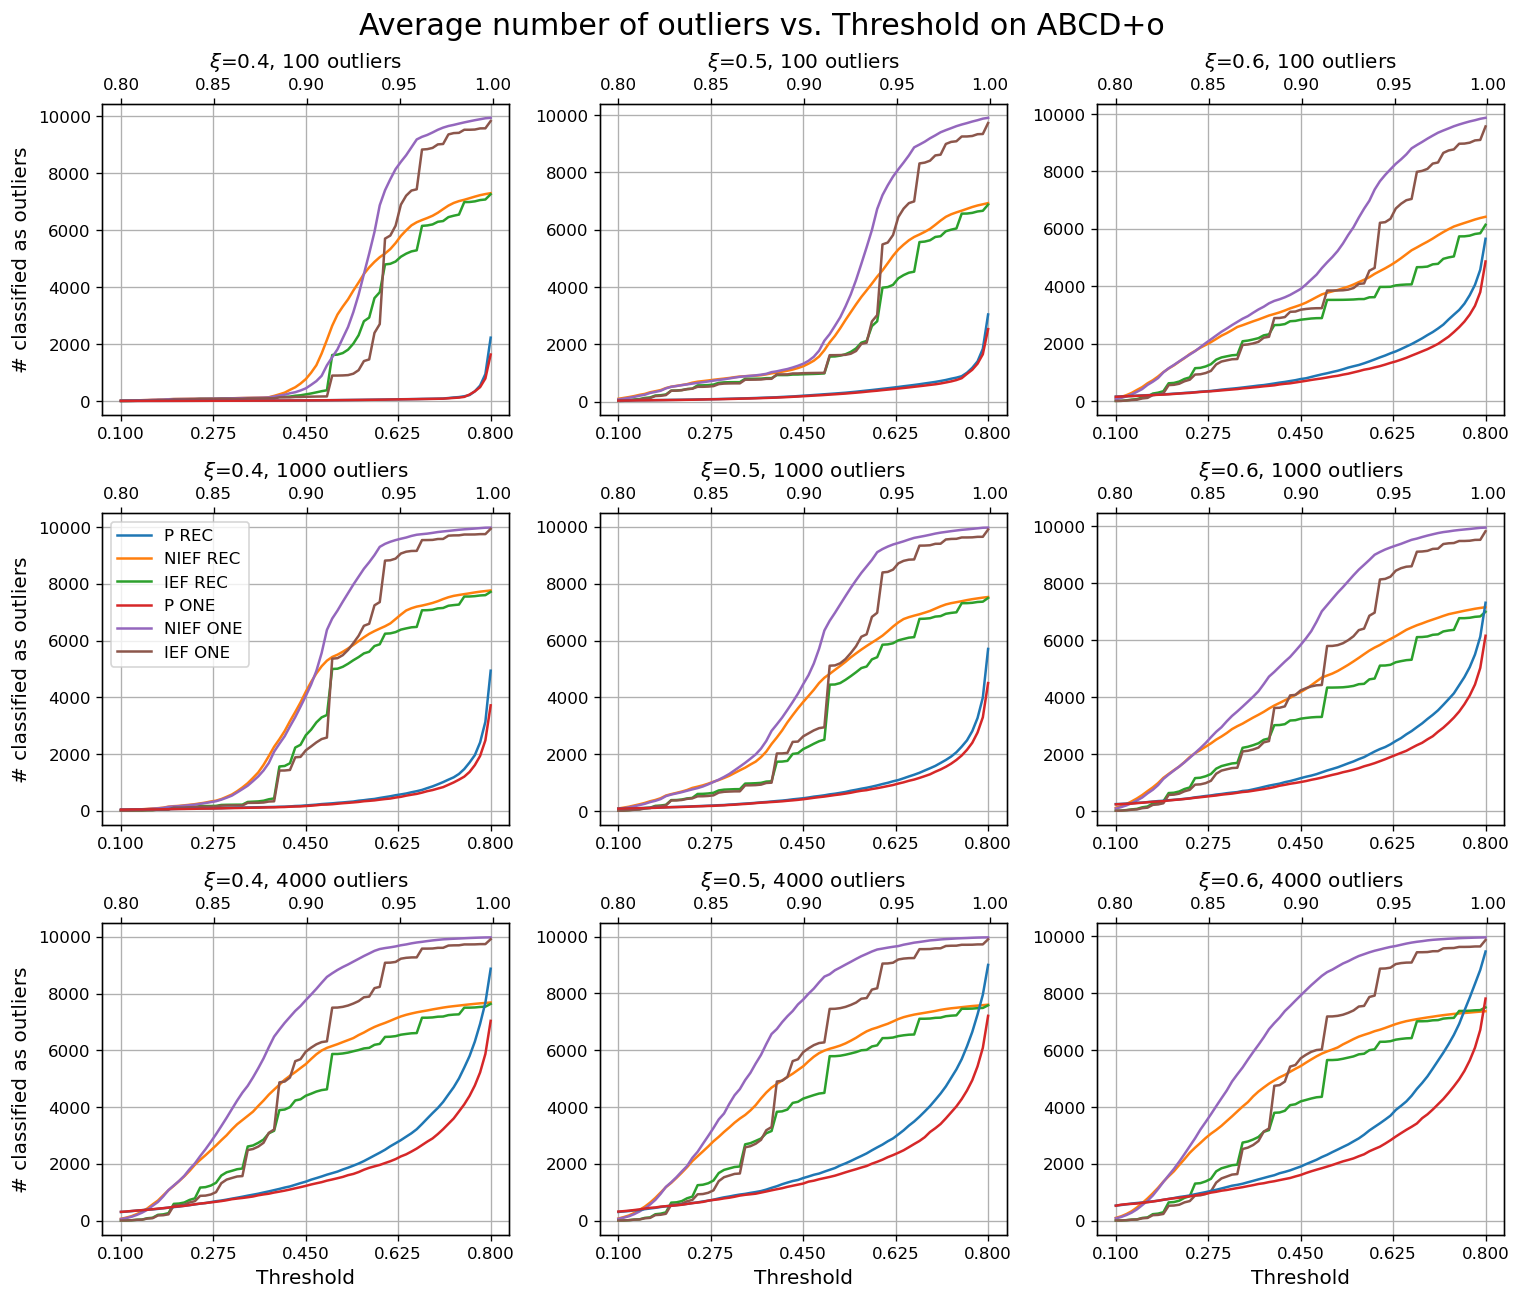

In [18]:

options = [
    #[pcout_pruned_rec, "P COUT REC"],
    #[niefcout_pruned_rec, "NIEF COUT REC"],
    #[iefcout_pruned_rec, "IEF COUT REC"],
    #[ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    [p_pruned_one, "P ONE"],
    [nief_pruned_one, "NIEF ONE"],
    [ief_pruned_one, "IEF ONE"],
]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
colors = colors[:len(options)]

fig, axs = plt.subplots(3, 3)
for i, nout in enumerate(NOUTS):
    for j, xi in enumerate(XIS):
        lines = []
        twy = axs[i,j].twiny()
        for o, (pruned, name) in enumerate(options):
            f1 = np.mean(np.sum(pruned[:, i, j, :, :], axis=-1), axis=0)
            if name in ["NIEF REC", "IEF REC", "NIEF ONE", "IEF ONE"]:
                lines += axs[i, j].plot(ief_cuts, f1, label=name, c=colors[o])
            elif name in ["P REC", "P ONE"]:
                lines += twy.plot(p_cuts, f1, label=name, c=colors[o])
            else:
                print(f"No cuts option for {name}")
        labels = [l.get_label() for l in lines]

        # Align tick marks, 5 looks good
        n_ticks = 5
        ief_ticks = np.linspace(np.min(ief_cuts), np.max(ief_cuts), n_ticks)
        axs[i,j].set_xticks(ief_ticks)
        p_ticks = np.linspace(np.min(p_cuts), 1, n_ticks)
        twy.set_xticks(p_ticks)

        axs[i, j].grid()
        axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("# classified as outliers", fontsize=12)
axs[1, 0].set_ylabel("# classified as outliers", fontsize=12)
axs[2, 0].set_ylabel("# classified as outliers", fontsize=12)
axs[2, 0].set_xlabel("Threshold", fontsize=12)
axs[2, 1].set_xlabel("Threshold", fontsize=12)
axs[2, 2].set_xlabel("Threshold", fontsize=12)
axs[1, 0].legend(lines, labels)
plt.suptitle(f"Average number of outliers vs. Threshold on ABCD+o", fontsize=18)

fig = plt.gcf()
fig.set_size_inches(12.8, 11)
fig.set_dpi(120)
fig.tight_layout()

## Consider Testing
I think it's fine to only consider the simplest pruning strategy.
Either (a) one shot prune below threshhold, or (b) multiround prune while below threshhold
(a) takes a threshhold parameter
(b) takes a threshhold parameter, and a max prunes per round parameter (which can perhaps be automatically guess assuming we want something like 10 rounds).

1. ABCDo range of usable F1 scores for predicting outliers. Test each score with each pruning method.
2. Real graphs (SNAP), probably considering noise as not in a strong commuity (given by strongtest community labels available)

A test, how well it could do can be measured by the max F1 score.
Maybe we consider viable parameter options anything within 10% of the max F1 score.

Hopefully at least one pair of score/method shows enough promise with some parameters to be considered usable.


Try on real graphs from SNAP instead of a big and costly simulation. (SNAP is too big for this laptop. Consider running with more RAM or using sn version)

# Real Graphs

100%|██████████| 61/61 [00:00<00:00, 129.57it/s]


CPU times: user 2.5 s, sys: 2 μs, total: 2.5 s
Wall time: 2.5 s


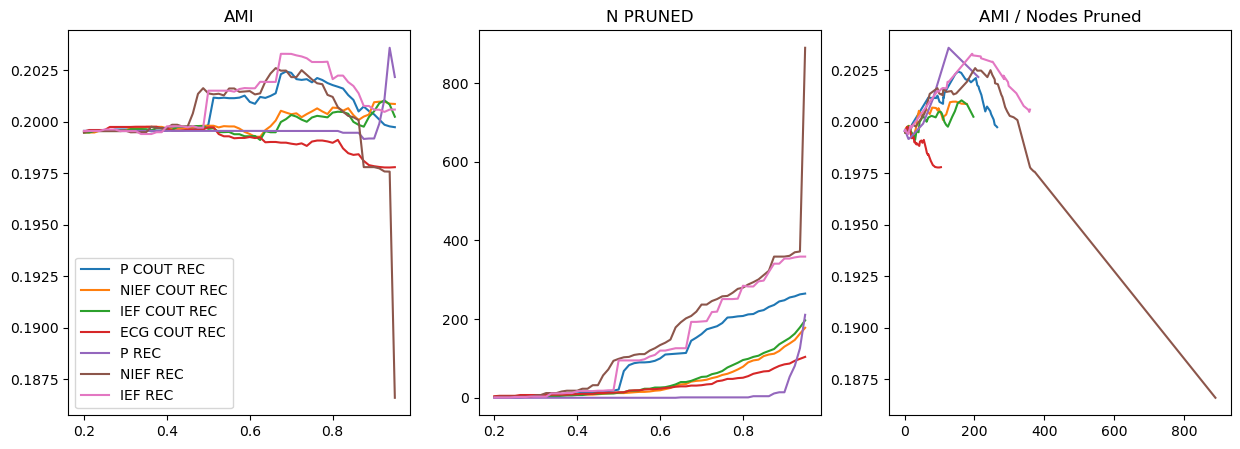

In [14]:
%%time
g = ig.Graph.Read_GML("real_data/citeseer.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.95, 61)
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()

100%|██████████| 61/61 [00:20<00:00,  2.91it/s]


CPU times: user 38.8 s, sys: 16 ms, total: 38.8 s
Wall time: 38.8 s


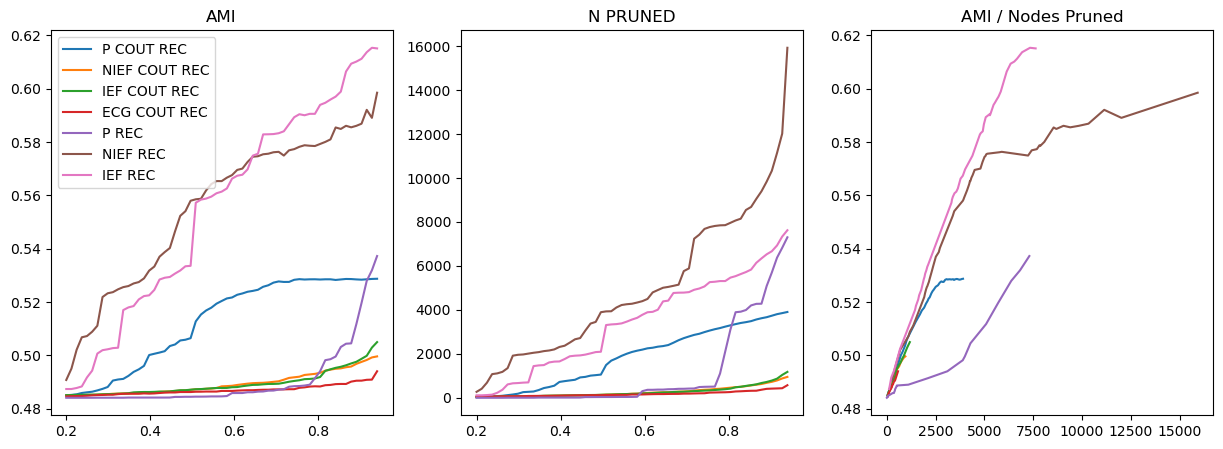

In [ ]:
%%time
g = ig.Graph.Read_GML("real_data/as.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.94, 61)  # TODO some error cutting at .95?
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()

100%|██████████| 61/61 [00:16<00:00,  3.74it/s]


CPU times: user 40.6 s, sys: 20 ms, total: 40.6 s
Wall time: 40.6 s


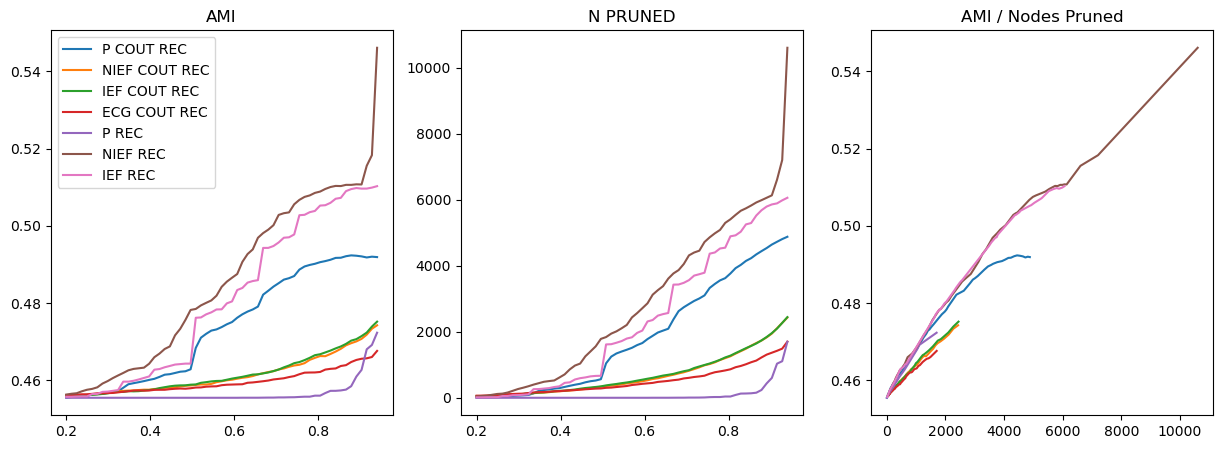

In [18]:
%%time
g = ig.Graph.Read_GML("real_data/cora_full.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.94, 61)
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()

100%|██████████| 61/61 [00:00<00:00, 109.52it/s]


CPU times: user 2.8 s, sys: 80 ms, total: 2.88 s
Wall time: 2.88 s


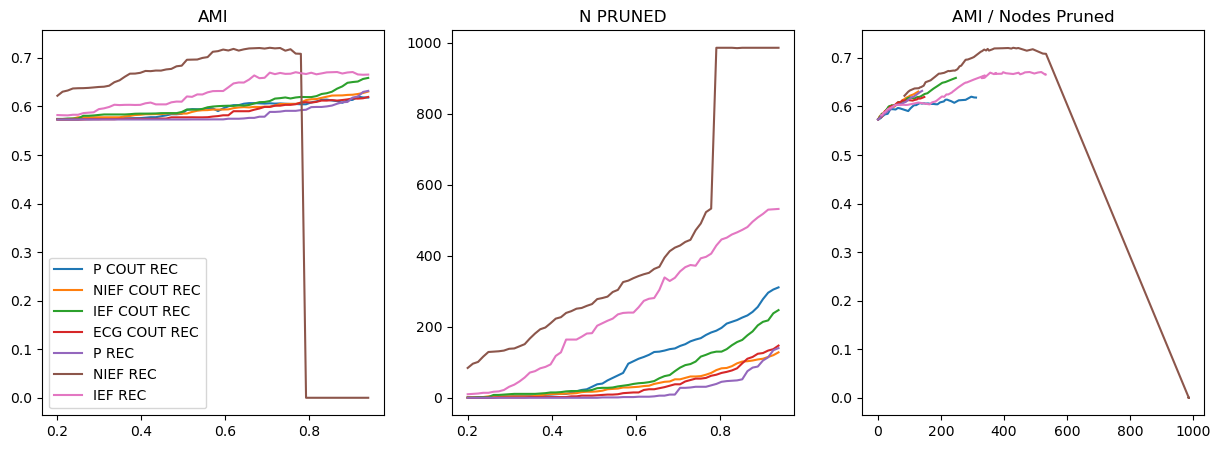

In [20]:
%%time
g = ig.Graph.Read_GML("real_data/eu-core.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.94, 61)
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()

<timed exec>:1: RuntimeWarning: Unterminated entity or stray & character found, will be returned verbatim. at src/io/gml.c:148
100%|██████████| 61/61 [00:00<00:00, 216.21it/s]


CPU times: user 1.88 s, sys: 0 ns, total: 1.88 s
Wall time: 1.88 s


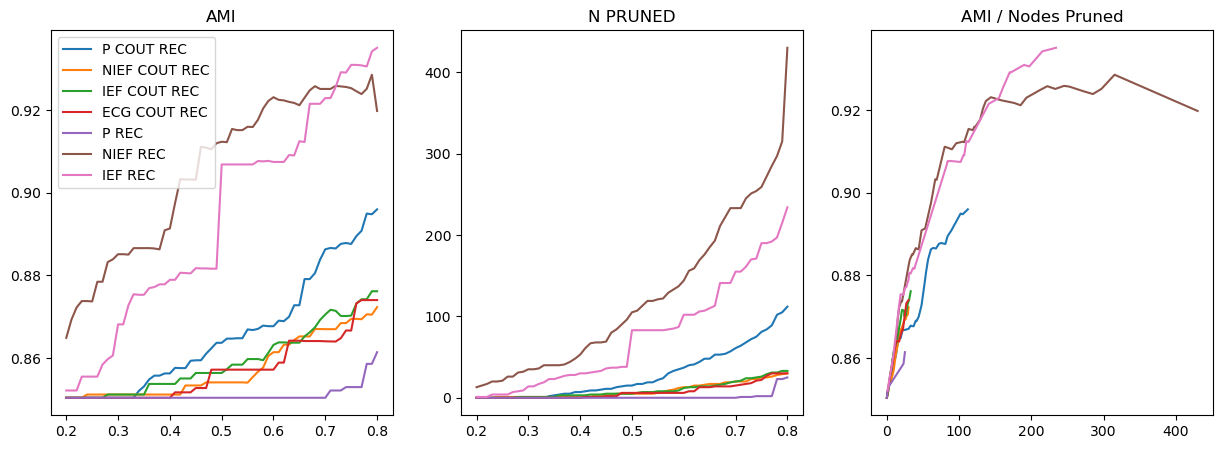

In [22]:
%%time
g = ig.Graph.Read_GML("real_data/eurosis.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.8, 61)
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()